In [7]:
import pickle
from glob import glob
import numpy as np

In [8]:
# ----------------------------------------------------------------------------------------------------------
# In this cell, we load all matching .pkl data files for 1-push tasks, extract episodes where a solution 
# was found, and compute the per-region success rates (solutions/pushes). We aggregate these results for 
# later analysis, making sure to not double-count regions within an episode.
# ----------------------------------------------------------------------------------------------------------

# Initialize counter for number of files processed
search_push_data = []
search_total_pushes = []

search_per_env_per_neighbor = {}
search_region_opening_attempts = 0
search_success_region_opening_attempts = 0
sols = 0
total_count = 0
double_sols = 0
files_no_sols = []
env_sols = 0
# Path to the data files (pkl files containing pickled episode results)
# data_dir = "/common/users/dm1487/namo_data/dec1/aug9_envs/2_push_train_first_solution/**/*.pkl"
# data_dir = "/common/users/dm1487/namo_data/dec1/aug9_envs/2_push_train_first_solution/**/*.pkl"
data_dir = "/common/users/dm1487/namo_data/dec2/aug9_envs/2_push_train/**/*.pkl"
# data_dir = "/common/users/dm1487/namo_data/dec2/aug9_envs/1_push_train/**/*.pkl"

xml_file_set = set()

# Iterate through all .pkl files that match the data_dir pattern
# BUG: glob() here refers to the glob function from the glob module, but glob.glob() 
# does not expand ** (recursive glob) unless you pass recursive=True.
for file in glob(data_dir, recursive=True):
    try:
        # Attempt to open and load each pickle file
        with open(file, "rb") as f:
            data = pickle.load(f)
            one_sol = False
            episode_results = data['episode_results']
            for ep_idx in range(len(episode_results)):
                xml_file = episode_results[ep_idx]['xml_file']
                xml_file_name = "_".join(episode_results[ep_idx]['xml_file'].split('/')[-4:])
                if "easy" in xml_file_name:
                    continue
                if xml_file_name not in xml_file_set:
                    xml_file_set.add(xml_file_name)
                    search_per_env_per_neighbor[xml_file_name] = {}
                
                if episode_results[ep_idx]['solution_found']:
                    sols += 1
                    one_sol = True
                    region_label = episode_results[ep_idx]['algorithm_stats']['neighbour_region_label']
                    if region_label not in search_per_env_per_neighbor[xml_file_name]:
                        search_per_env_per_neighbor[xml_file_name][region_label] = {
                            'max_depth_reached': [],
                            'xml_file': xml_file,
                        }
                    search_per_env_per_neighbor[xml_file_name][region_label]['max_depth_reached'].append(episode_results[ep_idx]['max_depth_reached'])
                    if episode_results[ep_idx]['max_depth_reached'] > 1:
                        double_sols += 1
                        # print(episode_results[ep_idx])
                
                total_count += 1
            if one_sol:
                env_sols += 1
            else:
                files_no_sols.append(xml_file)
            
    except Exception as e:
        # Print the error if something goes wrong, then continue to the next file
        print("Error in search data collection:")
        print(e)
        continue
    
print(sols, double_sols, double_sols/sols, sols/total_count)


Error in search data collection:
No module named 'namo_rl'
Error in search data collection:
No module named 'namo_rl'
Error in search data collection:
No module named 'namo_rl'
Error in search data collection:
No module named 'namo_rl'
Error in search data collection:
No module named 'namo_rl'
Error in search data collection:
No module named 'namo_rl'
119636 52325 0.43736835066367985 0.9863713939433914


In [9]:
env_sols

9821

In [10]:
count = 0
total_count = 0
double_files = []
for env in search_per_env_per_neighbor:
    for region in search_per_env_per_neighbor[env]:
        total_count += 1        
        if np.unique(np.array(search_per_env_per_neighbor[env][region]['max_depth_reached']))[0] == 2:
            count += 1
            double_files.append(search_per_env_per_neighbor[env][region]['xml_file'])

print(count, total_count, count/total_count)

5344 17898 0.29858084702201365


In [11]:
len(double_files), double_sols/count

(5344, 9.791354790419161)

In [9]:
import sys
sys.path.insert(0, '/common/home/dm1487/robotics_research/ktamp/namo')

from scripts.generate_xml_manifest import create_manifest
result = create_manifest(double_files, "/common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push_train.txt")

Processing 5771 files (excluding _temp.xml)
Checking for duplicate paths...

  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_1075a.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_1075c.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_2917a.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_2917b.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_2917c.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_2917e.xml: 2 occurrences
  /common/users/shared/robot_learning/dm1487/namo/mj_env_configs/aug9/medium/set1/benchmark_1/env_config_748a.xml: 2 occurrences
  /common/user

In [10]:
manifest_file_1 = "/common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push_train.txt"
with open(manifest_file_1, "r") as f:
    lines_1 = f.readlines()
    
manifest_file_2 = "/common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push.txt"
with open(manifest_file_2, "r") as f:
    lines_2 = f.readlines()
    
print(len(set(lines_1)), len(set(lines_2)), len(set(lines_1) - (set(lines_2))))

5184 5332 4067


In [364]:
import sys
sys.path.insert(0, '/common/home/dm1487/robotics_research/ktamp/namo')

left_files = list(set(lines_1) - (set(lines_2)))
from scripts.generate_xml_manifest import create_manifest
result = create_manifest(left_files, "/common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push_train.txt")

Processing 4067 files (excluding _temp.xml)
Checking for duplicate paths...
After deduplication: 4067 unique files
Sorting files...
Shuffling with seed=42...
Writing manifest to /common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push_train.txt...

Manifest created: /common/users/shared/robot_learning/dm1487/namo/manifests/aug9_medium/manifest_2push_train.txt
Total files: 4067


In [9]:
img_dir = "/common/users/dm1487/namo_data/images/nov30/1_push_train/easy"

for data_file in glob(img_dir + "/**/*.npz", recursive=True):
    data = np.load(data_file)
    break

KeyboardInterrupt: 

In [51]:
list(data.keys())

['robot',
 'goal',
 'movable',
 'static',
 'reachable',
 'target_object',
 'target_goal',
 'goal_region',
 'local_target_object',
 'local_target_goal',
 'local_goal_region',
 'local_static',
 'local_movable',
 'episode_id',
 'task_id',
 'algorithm',
 'solution_depth',
 'search_time_ms',
 'nodes_expanded',
 'robot_goal',
 'xml_file',
 'difficulty_label',
 'difficulty_score',
 'num_goal_horizons',
 'action_object_ids',
 'action_targets',
 'local_object_center',
 'local_object_theta',
 'local_bounds',
 'local_crop_size_meters',
 'local_resolution',
 'has_local_masks']

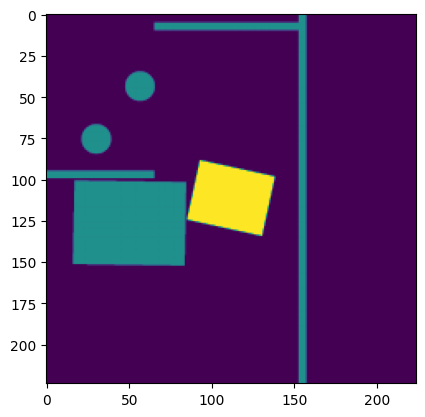

In [52]:
from matplotlib import pyplot as plt
plt.imshow(data['local_movable'] + data['local_static'] + data['local_target_object'] + data['local_goal_region'])

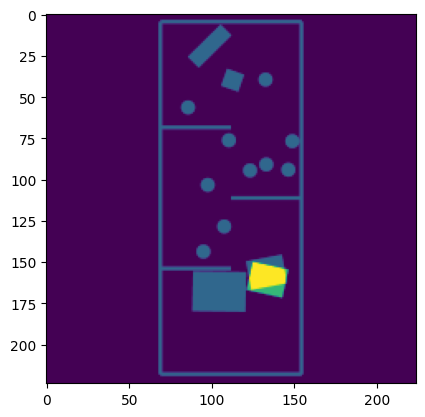

In [53]:
from matplotlib import pyplot as plt
plt.imshow(data['movable'] + data['static'] + data['goal_region'] + data['target_object'] + data['target_goal']) #  + data['local_target_object'] + data['local_goal_region'])